### Scraping the data from the IAAF website to build Pandas DataFrames. This part of the code has been adapted from: https://towardsdatascience.com/web-scraping-html-tables-with-python-c9baba21059 ###

In [1]:
import requests
import lxml.html as lh
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

/home/roberto/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# get url and create a page
url1='http://www.iaaf.org/records/all-time-toplists/sprints/100-metres/outdoor/men/senior?page=1'
url2='http://www.iaaf.org/records/all-time-toplists/sprints/200-metres/outdoor/men/senior?page=1'
# need this header to open the page from my laptop
headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:64.0) Gecko/20100101 Firefox/64.0'}
page1 = requests.get(url1, headers=headers)
page2 = requests.get(url2, headers=headers)

# store the contents of the website
doc1 = lh.fromstring(page1.content)
doc2 = lh.fromstring(page2.content)

# parse data that are stored between <tr>..</tr> of HTML
tr1_elements = doc1.xpath('//tr')
tr2_elements = doc2.xpath('//tr')

# in our case the table starts at position 18 (with the header)
tr1_elements = tr1_elements[18:]
tr2_elements = tr2_elements[18:]

# create final lists
tr1_elements_final=tr1_elements[:]
tr2_elements_final=tr2_elements[:]

# number of pages of results we want to include
np=10

ip=2
while ip<=np:
    url1='http://www.iaaf.org/records/all-time-toplists/sprints/100-metres/outdoor/men/senior?page=' + str(ip)
    url2='http://www.iaaf.org/records/all-time-toplists/sprints/200-metres/outdoor/men/senior?page=' + str(ip)
    page1 = requests.get(url1, headers=headers)
    page2 = requests.get(url2, headers=headers)
    doc1 = lh.fromstring(page1.content)
    doc2 = lh.fromstring(page2.content)
    tr1_elements_tmp = doc1.xpath('//tr')
    tr2_elements_tmp = doc2.xpath('//tr')
    
    # without including the header again
    tr1_elements_final += tr1_elements_tmp[19:]
    tr2_elements_final += tr2_elements_tmp[19:]
    ip+=1

In [3]:
# create empty list
col1=[]
col2=[]

#For each row, store each first element (header) and an empty list
i=0
for t in tr1_elements_final[0]:
    i+=1
    name=t.text_content()
    name=name.strip()
    #print '%d:"%s"'%(i,name)
    col1.append((name,[]))

i=0
for t in tr2_elements_final[0]:
    i+=1
    name=t.text_content()
    name=name.strip()
    #print '%d:"%s"'%(i,name)
    col2.append((name,[]))

In [4]:
#Since our first row is the header, data is stored on the second row onwards
for j in range(1,len(tr1_elements_final)):
    #T is our j'th row
    T=tr1_elements_final[j]
    
    #If row is not of size 11, the //tr data is not from our table 
    if len(T)!=11:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content()
        data=data.strip()
        #Append the data to the empty list of the i'th column
        col1[i][1].append(data)
        #Increment i for the next column
        i+=1
        
for j in range(1,len(tr2_elements_final)):
    #T is our j'th row
    T=tr2_elements_final[j]
    
    #If row is not of size 11, the //tr data is not from our table 
    if len(T)!=11:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content()
        data=data.strip()
        #Append the data to the empty list of the i'th column
        col2[i][1].append(data)
        #Increment i for the next column
        i+=1

In [5]:
Dict1={title:column for (title,column) in col1}
Dict2={title:column for (title,column) in col2}

# there's a key with all blank entries so we get rid of it
del Dict1['']
del Dict2['']

# create DataFrames
df1=pd.DataFrame(Dict1)
df2=pd.DataFrame(Dict2)

# changing header name
df1.rename(columns={'Mark':'100m'}, inplace=True)
df2.rename(columns={'Mark':'200m'}, inplace=True)

### Creating combined 100-200m list ###

In [6]:
df3=pd.merge(df1[['Competitor','100m']], df2[['Competitor','200m']], on='Competitor')

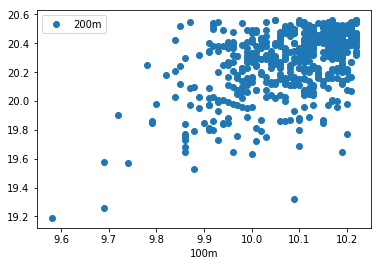

In [7]:
df3 = df3.astype({'100m': float, '200m': float})
df3.plot(x='100m', y='200m', style='o')

### Performing linear regression using Statsmodels and adapting code from https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9 ###

In [8]:
Xval = df3['100m']
Yval = df3['200m']
Xval = sm.add_constant(Xval)

modelsm = sm.OLS(Yval, Xval).fit()

YpredictionsSM = modelsm.predict(Xval)
modelsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   200m   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     155.6
Date:                Thu, 27 Jun 2019   Prob (F-statistic):           2.16e-31
Time:                        11:43:49   Log-Likelihood:                 96.442
No. Observations:                 517   AIC:                            -188.9
Df Residuals:                     515   BIC:                            -180.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8169      0.838     11.721      0.000       8.171      11.462
100m           1.0368      0.083     12.474      0.000       0.873       1.200
==============================================================================
Omnibus:                       56.782   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.776
Skew:                          -0.776   Prob(JB):                     2.88e-18
Kurtosis:                       4.159   Cond. No.                         963.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
# percent difference between true value and model prediction
reldiffsm=100*(Yval-YpredictionsSM)/Yval

# test model
modelsm.predict((1.0,9.72))

array([19.894167])

### Performing linear regression using scikit-learn and adapting code from https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9 ###

In [10]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
modelsk = lm.fit(Xval,Yval)

YpredictionsSK = lm.predict(Xval)

In [11]:
# get R-squared
R2sk=lm.score(Xval,Yval)

# get slope
coefsk=lm.coef_
print 'coeff_sk = ',coefsk[1]

# get intercept
constsk=lm.intercept_
print 'intercept_sk = ',constsk

# check that two tools give same predictions
#YpredictionsSM-YpredictionsSK

coeff_sk =  1.0367603115095
intercept_sk =  9.81685677286764
